In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import calpred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import os
import subprocess

[Durvasula & Price 2023](https://www.medrxiv.org/content/10.1101/2023.09.22.23295969v1) proposes three types of GxE:
1. Imperfect genetic correlation: there is an imperfect genetic correlation across E bins due to different SNP effect sizes in different E bins
2. Varying genetic variance: differences in SNP-heritability across E bins due to uniform amplification of SNP effect sizes across E bins; the environmental variance may either remain constant or vary across E bins. 
3. Proportional amplification: the genetic and environmental variance vary proportionately across E bins due to proportionate scaling of SNP effect sizes and environmental effect sizes across E bins, so that SNP-heritability remains the same across E bins.

Next, we simulate these three scenarios of GxE and discuss how CalPred behaves in each scenario.

We always fit `y ~ PRS + PRSxE | E`

In [2]:
def format_df(prs, y):
    df = {"PRS": [], "E": [], "y": []}
    for i in range(2):
        df["PRS"].extend(prs[:, i])
        df["E"].extend([i] * len(prs))
        df["y"].extend(y[:, i])
    df = pd.DataFrame(df)
    df["PRSxE"] = df["PRS"] * df["E"]

    mean_coef, mean_se, sd_coef, sd_se = calpred.fit(
        y=df["y"], x=df[["PRS", "PRSxE"]], z=df[["E"]]
    )
    df["predmean"], df["predsd"] = calpred.predict(
        x=df[["PRS", "PRSxE"]], z=df[["E"]], x_coef=mean_coef, z_coef=sd_coef
    )
    return df


def plot_df(df, figsize=(5, 2.5)):

    fig, axes = plt.subplots(
        figsize=figsize, dpi=150, ncols=2, sharex=True, sharey=True
    )
    for i in range(2):
        sub_df = df[df["E"] == i]
        ax = axes[i]
        calpred.plot_scatter_calibration(x=sub_df["PRS"], y=sub_df["y"], ax=ax)
        ax.legend(loc="upper left", fontsize=7)
    fig.tight_layout()

    fig, axes = plt.subplots(
        figsize=figsize, dpi=150, ncols=2, sharex=True, sharey=True
    )
    for i in range(2):
        sub_df = df[df["E"] == i].reset_index(drop=True)
        ax = axes[i]
        calpred.plot_scatter_calibration(x=sub_df["predmean"], y=sub_df["y"], ax=ax)

        idx = sub_df.sort_values("PRS").index[int(len(sub_df) * 0.95)]
        x, ysd = sub_df["predmean"].values[idx], sub_df["predsd"].values[idx]
        ax.errorbar(
            x=[x],
            y=[x],
            yerr=ysd * 1.645,
            fmt=".",
            color="red",
            capsize=3,
            linewidth=1,
            label=f"ysd={ysd:.2f}",
        )

        ax.legend(loc="upper left", fontsize=8)
    fig.tight_layout()

# Scenario 1: imperfect genetic correlation

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 303.90it/s]


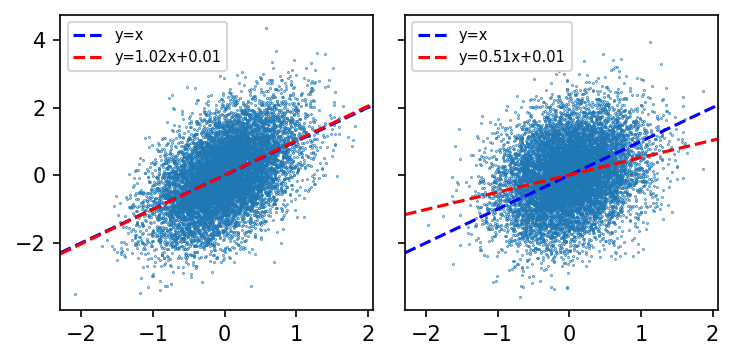

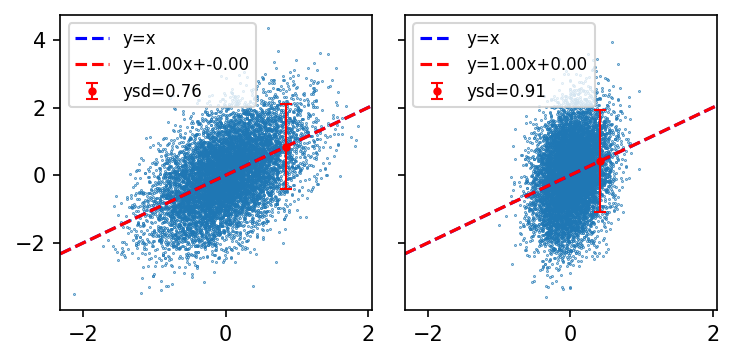

In [3]:
rep = 0

ymat, prsmat, gmat, emat, betamat, betaprsmat = calpred.simulate_gxe(
    scenario=1, hsq=0.5, rg=0.5, n_rep=10
)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]
df = format_df(prs, y)
plot_df(df)

# Scenario 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 383.48it/s]


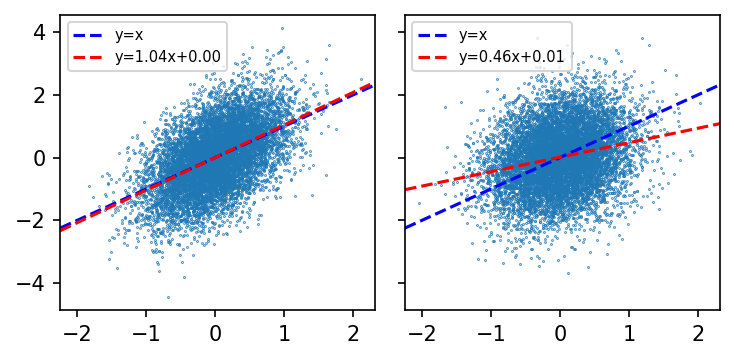

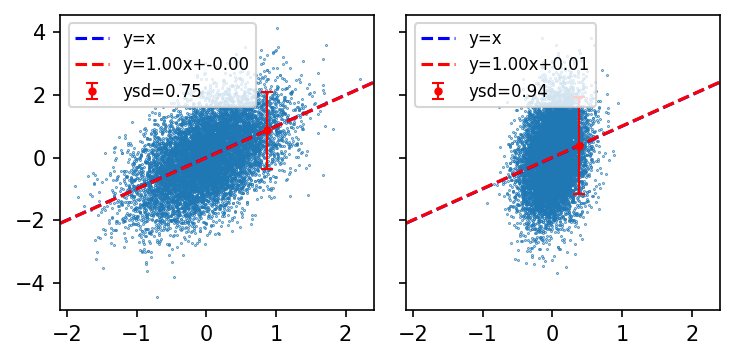

In [4]:
ymat, prsmat, gmat, emat, beta, betaprs = calpred.simulate_gxe(
    scenario=2, hsq1=0.5, hsq2=0.1
)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

df = format_df(prs, y)
plot_df(df)

# Scenario 3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 408.20it/s]


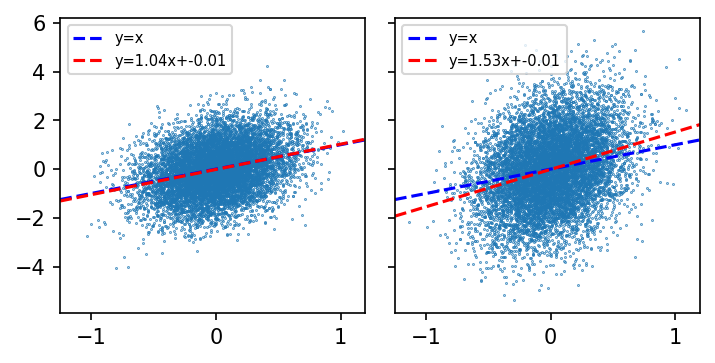

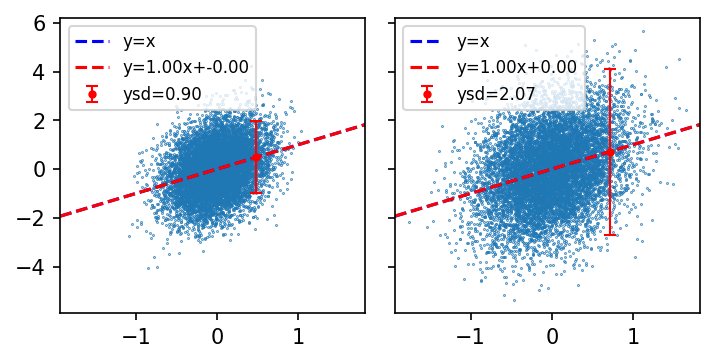

In [5]:
ymat, prsmat, gmat, emat, beta, betaprs = calpred.simulate_gxe(
    scenario=3, hsq=0.25, prop_amp=1.5
)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

df = format_df(prs, y)
plot_df(df)